# Self Driving Car Engineer Nanodegree

## Project 2 : Advanced Lane Finding 

---

### The main aim of this project is to implement the following steps:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---

## Import all the required functions

In [51]:
import pickle
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

__DEBUG__ = True

## Camera Calibration
#### The calibration of camera can be done using the chess board images provided in camera_cal folder

17  images were eligible for calibration


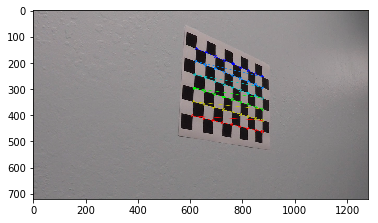

In [35]:
def camera_calibrate(images_list, nx_columns, ny_rows, root_folder = ""):
    object_points_superset = []
    image_points_superset = []
    eligible_images = 0
    for i in range(len(images_list)):
        img = cv2.imread(root_folder+images_list[i])
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
        gray_chess_board = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray_chess_board, (nx, ny), None)
        if ret == True:
            if __DEBUG__:
                # Draw and display the corners
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                plt.imshow(img)
            eligible_images = eligible_images + 1
            object_points_superset.append(objp)
            image_points_superset.append(corners)
            
    print(eligible_images, " images were eligible for calibration")
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points_superset, image_points_superset, 
                                                       gray_chess_board.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs
        

        
ret, mtx, dist, rvecs, tvecs = camera_calibrate(os.listdir("camera_cal"), 9, 6, "camera_cal//")

# Undistortion

#### Here, the image is undistorted using the mtx and dist parameters, that we got as output from the calibration of camera

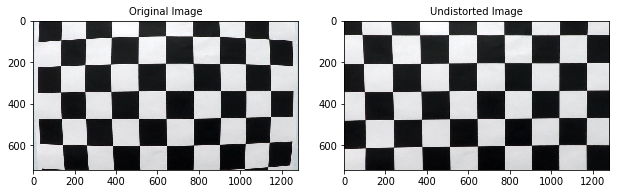

In [97]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

if __DEBUG__:
    #ret, mtx, dist, rvecs, tvecs = camera_calibrate(os.listdir("camera_cal"), 9, 6, "camera_cal//")
    test_image = cv2.imread("camera_cal//calibration1.jpg")
    undistorted_image = (undistort(test_image))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    f.tight_layout()
    ax1.imshow(test_image)
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(undistorted_image)
    ax2.set_title('Undistorted Image', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Sobel gradient masking and HLS masking

In [231]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, sobel_thresh=(0,255)):
    temp_img = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):    
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobely**2 + sobelx**2)
    scaled_gradmag = np.uint8(255*gradmag/np.max(gradmag))
    binary_output = np.zeros_like(gradmag)
    binary_output[(scaled_gradmag >= mag_thresh[0]) & (scaled_gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_direction = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(grad_direction)
    binary_output[(grad_direction >= thresh[0]) & (grad_direction <= thresh[1])] = 1
    return binary_output

def combined_threshold(image, sobel_kernel=15, threshold_array={'x':(20,100), 'y':(20,100), 'mag':(30,100), 'dir':(0.7, 1.3)}):
    gradx = abs_sobel_thresh(image, 'x', sobel_kernel, sobel_thresh=threshold_array['x'])
    grady = abs_sobel_thresh(image, 'y', sobel_kernel, sobel_thresh=threshold_array['y'])
    mag_binary = mag_thresh(image, sobel_kernel, mag_thresh=threshold_array['mag'])
    dir_binary = dir_threshold(image, sobel_kernel, thresh=threshold_array['dir'])

    combined_binary_image = np.zeros_like(dir_binary)
    combined_binary_image[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined_binary_image

def s_channel_threshold(image, s_thresh=(0,255)):
    hls_image = cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
    s_channel = hls_image[:,:,2]
    s_binary_image = np.zeros_like(s_channel)
    s_binary_image[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary_image

def l_channel_threshold(image, l_thresh=(0,255)):
    hls_image = cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
    l_channel = hls_image[:,:,1]
    l_binary_image = np.zeros_like(l_channel)
    l_binary_image[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    return l_binary_image

def h_channel_threshold(image, h_thresh=(0,255)):
    hls_image = cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
    h_channel = hls_image[:,:,0]
    h_binary_image = np.zeros_like(h_channel)
    h_binary_image[(h_channel > h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    return h_binary_image

def bitwise_and_binary_images(binary_image1, binary_image2):
    result_binary_image = np.zeros_like(binary_image1)
    result_binary_image[(binary_image1 == 1) & (binary_image2 == 1)] = 1
    return result_binary_image

def bitwise_or_binary_images(binary_image1, binary_image2):
    result_binary_image = np.zeros_like(binary_image1)
    result_binary_image[(binary_image1 == 1) | (binary_image2 == 1)] = 1
    return result_binary_image

def test_images(image_path):
    display_images = []
    testing_image = cv2.imread(image_path)
    testing_image = undistort(testing_image)
    #masked_image = combined_threshold(testing_image)
    threshold_array={'x':(50,180), 'y':(50,180), 'mag':(50,180), 'dir':(0.8, 1)}
    x_sobel = abs_sobel_thresh(testing_image, 'x',sobel_kernel=3, sobel_thresh=threshold_array['x'])
    y_soble = abs_sobel_thresh(testing_image, 'y', sobel_kernel=3, sobel_thresh=threshold_array['y'])
    mag_binary = mag_thresh(testing_image, sobel_kernel=3, mag_thresh=threshold_array['mag'])
    dir_binary = dir_threshold(testing_image, sobel_kernel=15, thresh=threshold_array['dir'])
    s_channel_image = s_channel_threshold(testing_image, (170,255))
    h_channel_image = h_channel_threshold(testing_image, (40,100))
    l_channel_image = l_channel_threshold(testing_image, (100,250))
    s_or_mag_image = bitwise_or_binary_images(s_channel_image, mag_binary)
    mag_and_dir_image = bitwise_and_binary_images(mag_binary, dir_binary)
    mag_or_dir_s_image = bitwise_or_binary_images(s_or_mag_image, mag_and_dir_image)
    mag_dir_s_l_image = bitwise_and_binary_images(mag_or_dir_s_image, l_channel_image)
    
    display_images.append([cv2.cvtColor(testing_image, cv2.COLOR_BGR2RGB), "Undistorted "+image_path.split("//")[1]])
    display_images.append([x_sobel, 'x sobel'])
    display_images.append([y_soble, 'y sobel'])
    display_images.append([mag_binary, 'mag_binary'])
    display_images.append([dir_binary, 'dir_binary'])
    display_images.append([s_channel_image, 's-channel'])
    display_images.append([l_channel_image, 'l-channel'])
    display_images.append([h_channel_image, 'h-channel'])
    display_images.append([s_or_mag_image, 's_or_mag_image'])
    display_images.append([mag_and_dir_image, 'mag_and_dir_image'])
    display_images.append([mag_or_dir_s_image, 'mag_or_dir_s_image'])
    display_images.append([mag_dir_s_l_image, 'mag_dir_s_l_image'])
    
    
    f, axes = plt.subplots(3, 4, figsize=(16, 9))
    axes = axes.flatten()
    f.tight_layout()
    #print (axes[0])
    #axes[0].imshow(cv2.cvtColor(testing_image, cv2.COLOR_BGR2RGB))
    for i in range(len(axes)):
        axes[i].imshow(display_images[i][0])
        axes[i].set_title(display_images[i][1], fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    


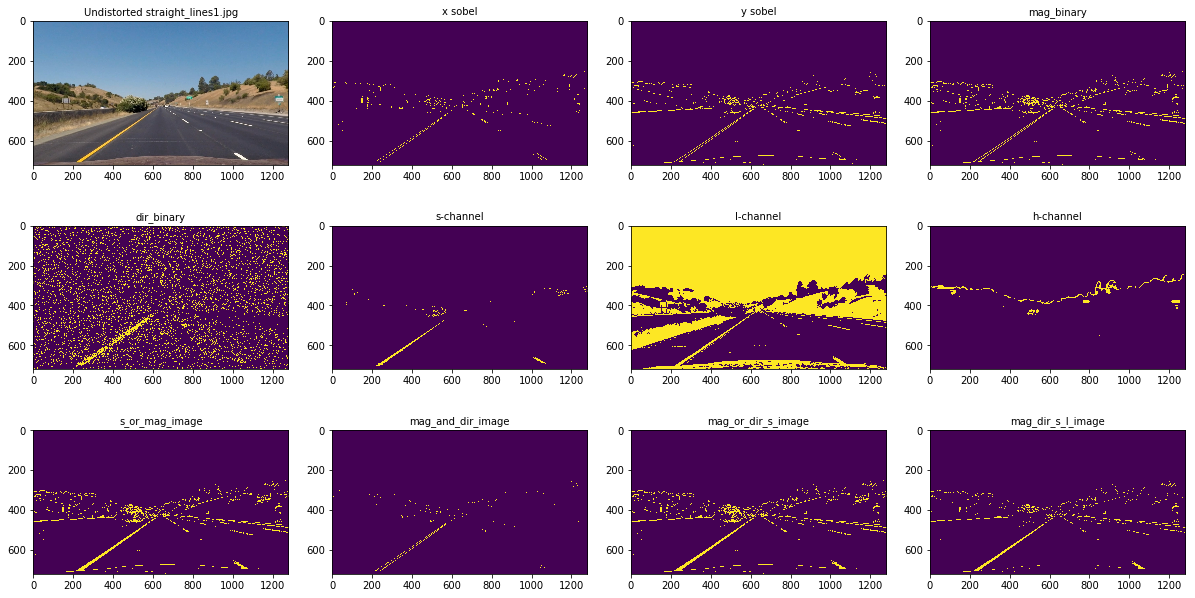

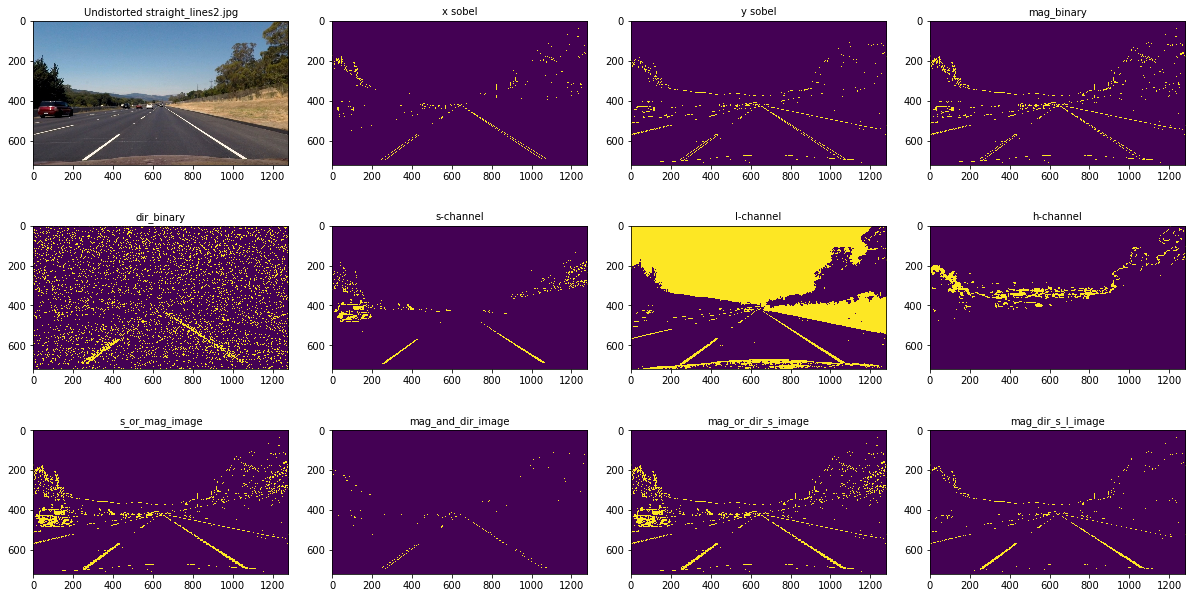

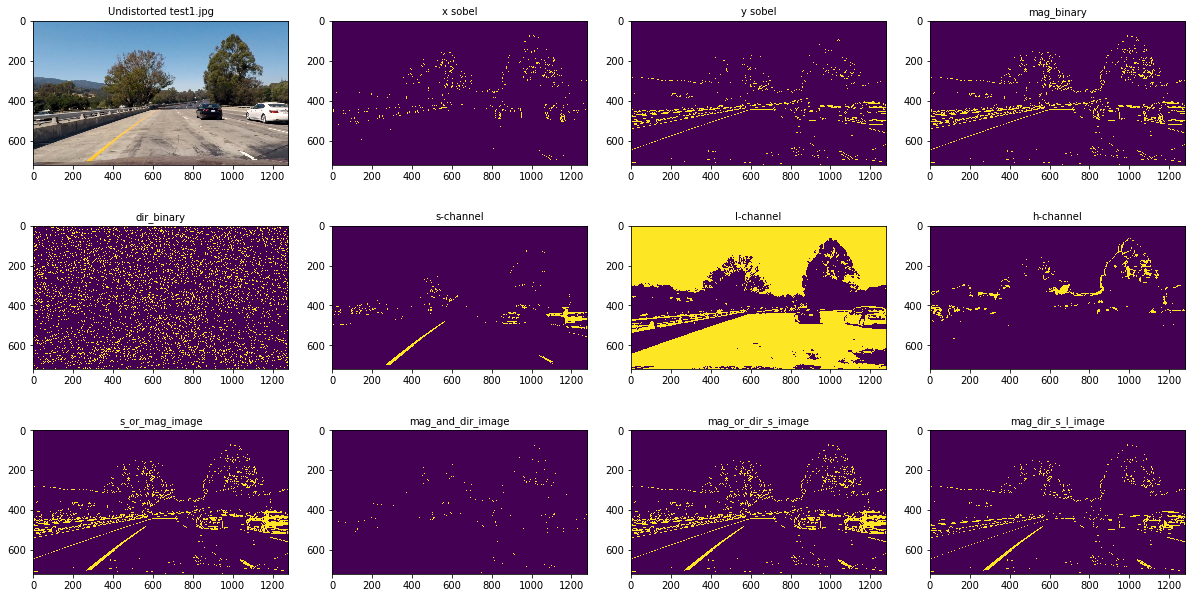

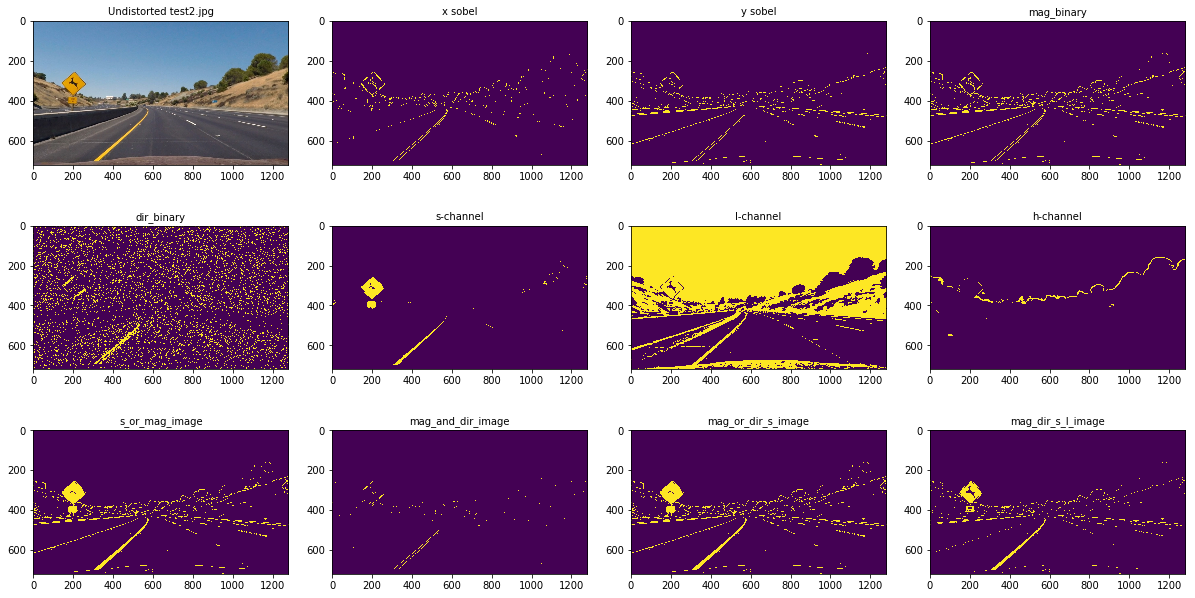

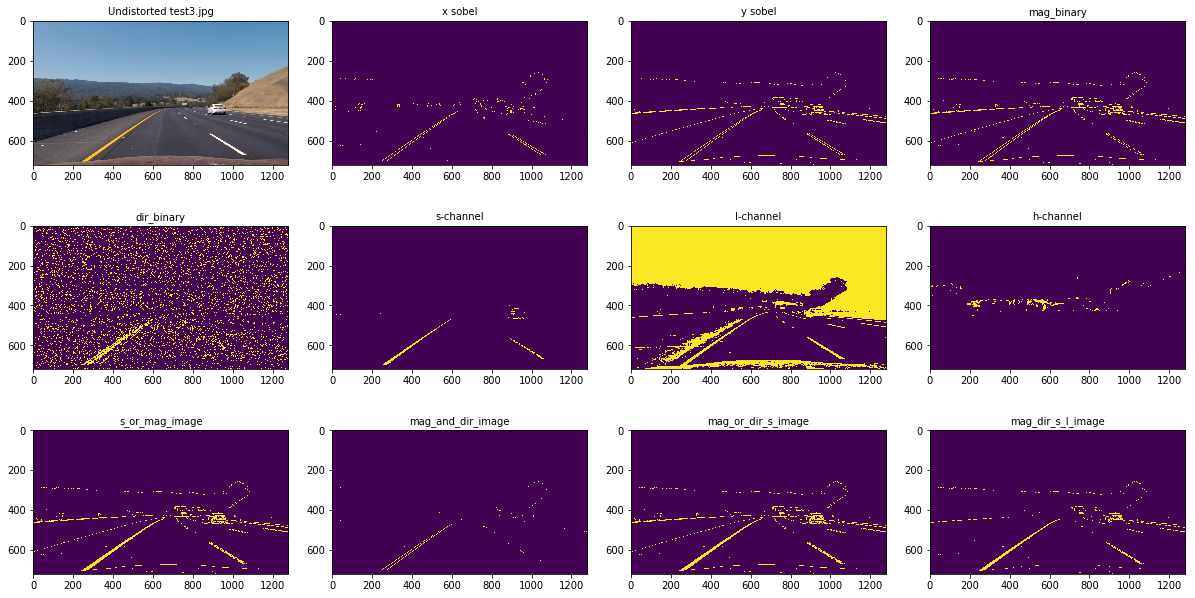

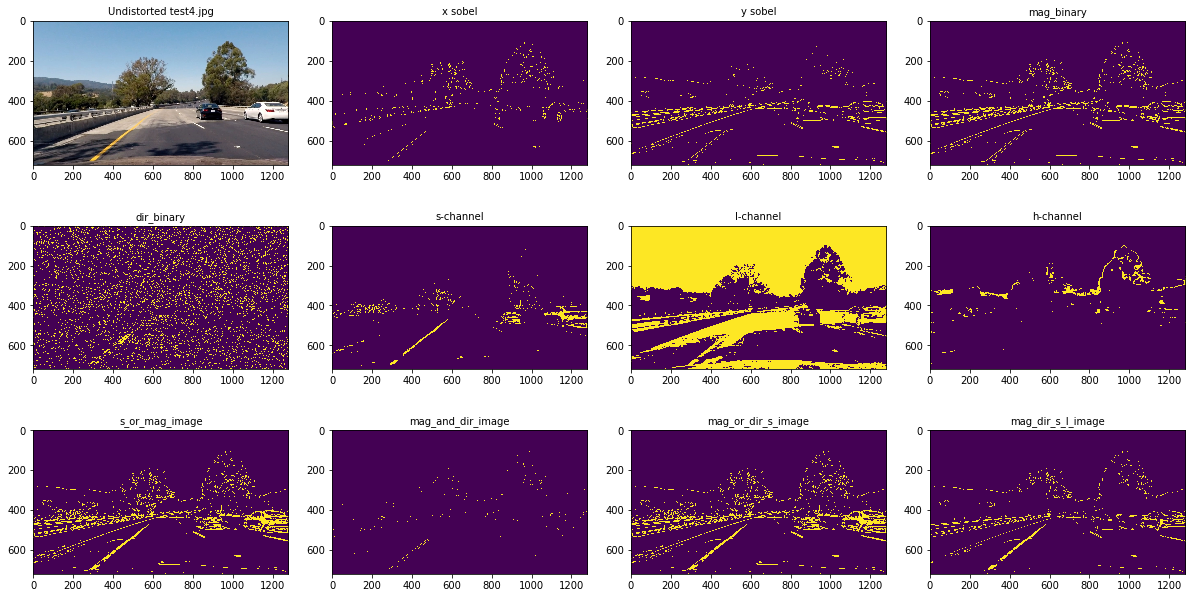

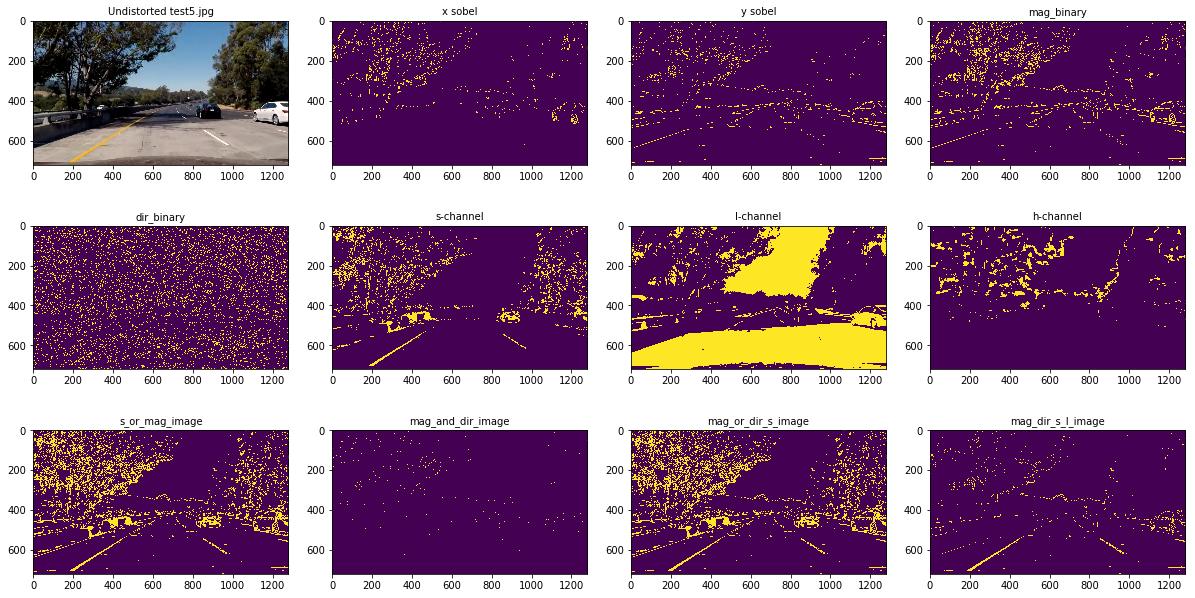

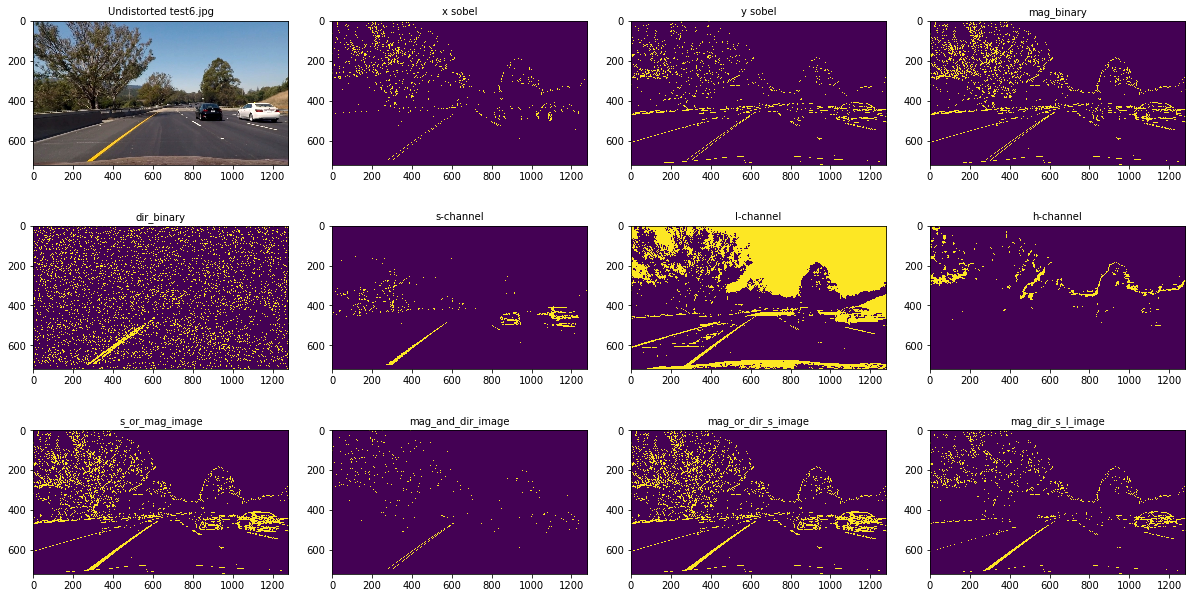

In [232]:
test_images("test_images//straight_lines1.jpg")
test_images("test_images//straight_lines2.jpg")
test_images("test_images//test1.jpg")
test_images("test_images//test2.jpg")
test_images("test_images//test3.jpg")
test_images("test_images//test4.jpg")
test_images("test_images//test5.jpg")
test_images("test_images//test6.jpg")

## Conclusion of above observation:
* The h-channel is of no use in finding the lane
* The s-channel works really good in identifying the lane lines
* The angular (a.k.a direction) binary finds the lane in road with darker shade, but also have too much noise
    - Hence, this can be combined with magnitude binary (using bitwise-and)
* The x and y sobel works good with road with darker shade and finding white lanes, so do the magnitude binary
    * Hence, the magnitude binary can be used alongside s-channel (bitwise-or) 
* The l-channel works good in road with darker shade, but when the road shade changes, no lanes are detected (pixels of enitre road is activated)
    * Hence, this can be used as a final filter, after the magnitude, direction and s-channel filtering

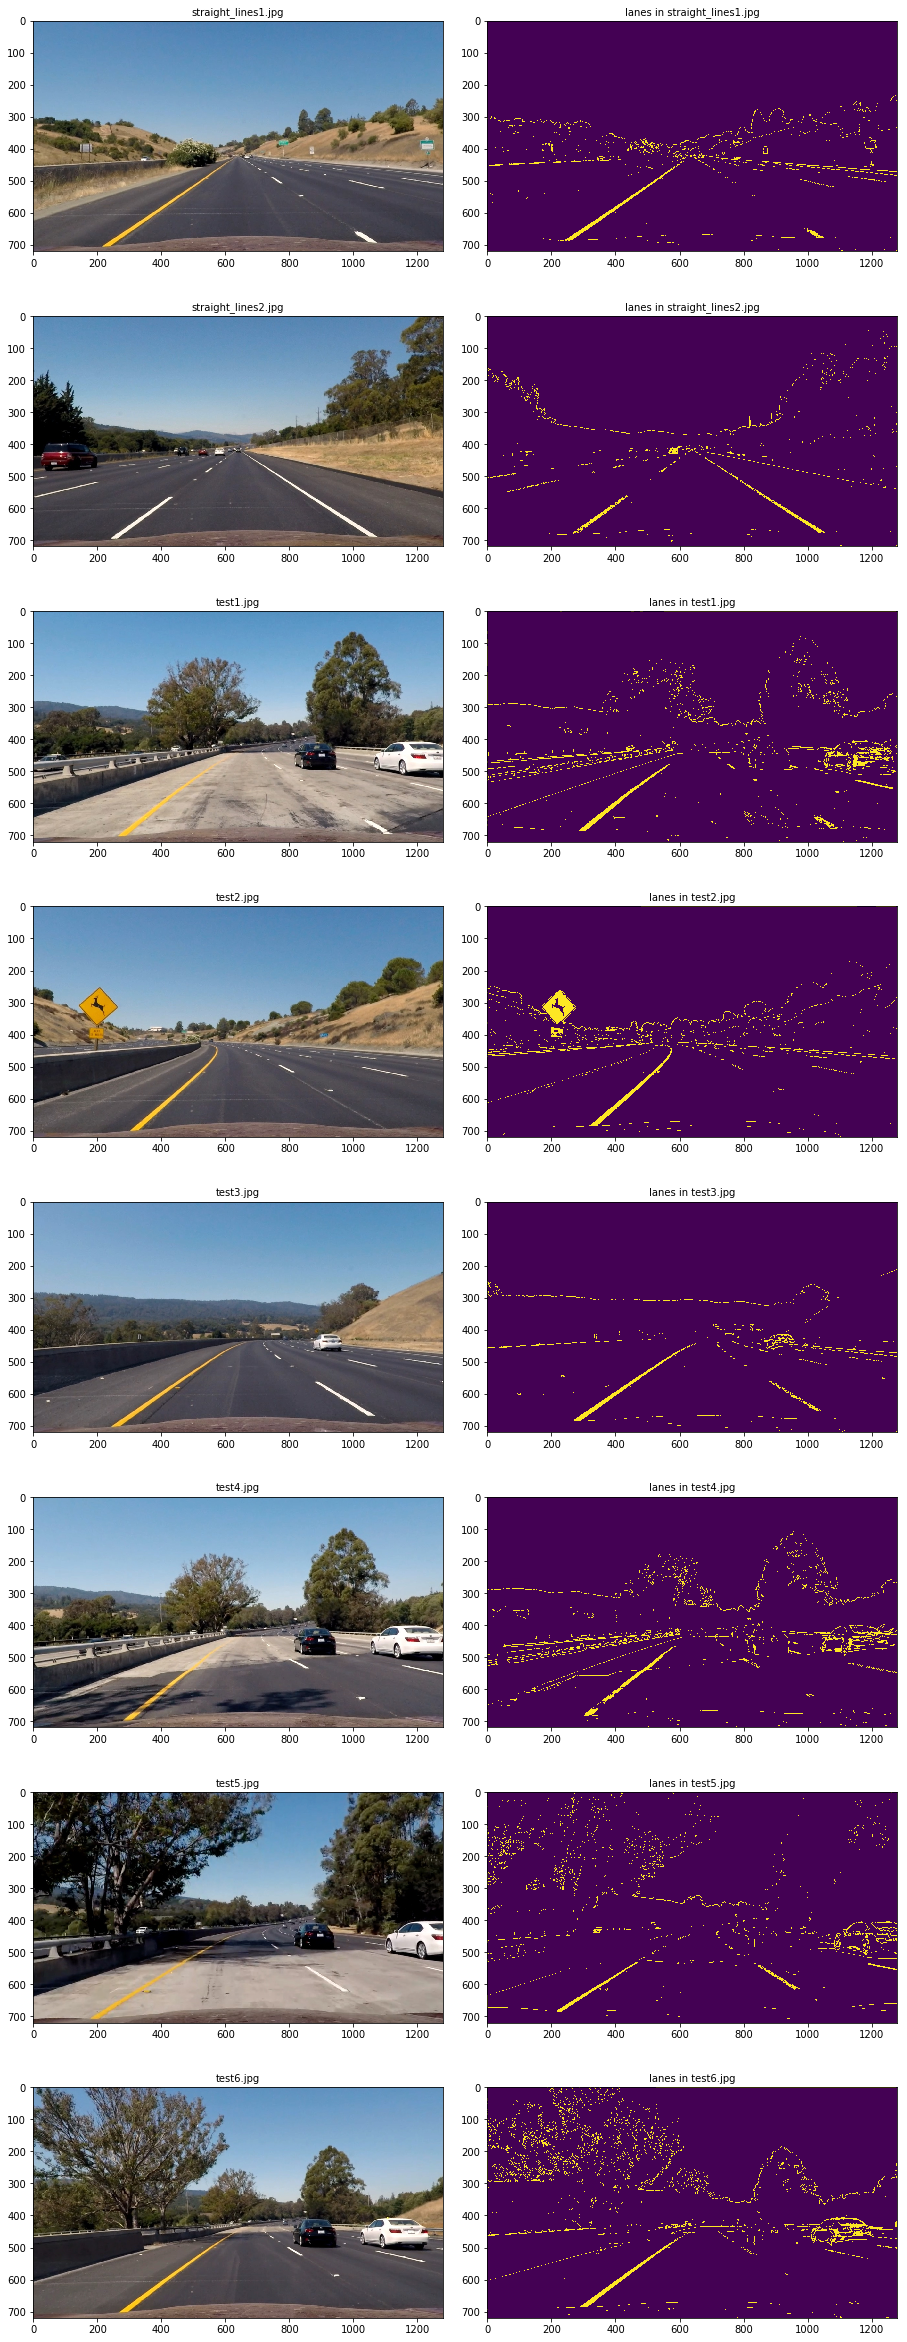

In [190]:
def lane_filter(image):
    threshold_array={'mag':(50,180), 'dir':(0.8, 1), 's':(170,255), 'l':(100,250)}
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=threshold_array['mag'])
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=threshold_array['dir'])
    s_channel_image = s_channel_threshold(image, threshold_array['s'])
    l_channel_image = l_channel_threshold(image, threshold_array['l'])
    s_or_mag_image = bitwise_or_binary_images(s_channel_image, mag_binary)
    mag_and_dir_image = bitwise_and_binary_images(mag_binary, dir_binary)
    mag_or_dir_s_image = bitwise_or_binary_images(s_or_mag_image, mag_and_dir_image)
    mag_dir_s_l_image = bitwise_and_binary_images(mag_or_dir_s_image, l_channel_image)
    return mag_dir_s_l_image

if __DEBUG__:
    display_images=[]
    for image_name in os.listdir("test_images"):
        test_image = cv2.imread("test_images//"+image_name)
        display_images.append([undistort(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)),image_name])
        display_images.append([lane_filter(test_image),"lanes in "+image_name])
    f, axes = plt.subplots(8, 2, figsize=(12, 36))
    axes = axes.flatten()
    f.tight_layout()
    for i in range(len(axes)):
        axes[i].imshow(display_images[i][0])
        axes[i].set_title(display_images[i][1], fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective change:
#### The perspective change requires Perspective transform matrix M, and inverse perspective transform matrix Minv to change it back to original perspective.
* We shall have a singleton class here, that produces the 2 matrices, as this will stay the same for entire process
* We shall consider the test image straight_lines1.jpg for computing these matrices

In [226]:
class Singleton_Perspective_Transform:
    
    def __init__(self):
        _src_points = np.float32([(203,720),(1100,720),(700,460),(582,460)])  #arbitrary points, manually obtained from image
        _dst_points = np.float32([(203,720),(1100,720),(1100,0),(203,0)])
        self.M = cv2.getPerspectiveTransform(_src_points,_dst_points)
        self.Minv = cv2.getPerspectiveTransform(_dst_points,_src_points)
    
    def warp_image(self, image):
        return cv2.warpPerspective(image, self.M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    
    def unwarp_image(self, image):
        return cv2.warpPerspective(image, self.Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    
perspective_transform = Singleton_Perspective_Transform()

def warp_image(image):
    return perspective_transform.warp_image(image)
def unwarp_image(image):
    return perspective_transform.unwarp_image(image)

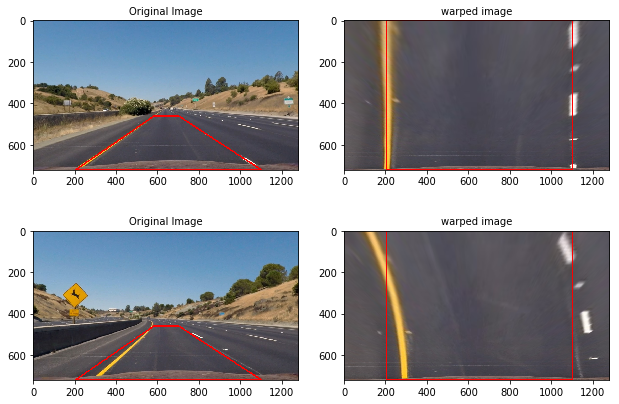

In [249]:
def test_warping():
    #original_image = mpimg.imread("test_images//straight_lines1.jpg")
    #cutved_image = mpimg.imread("test_images//test3.jpg")
    def draw_lines_on_original_image(img):
        cv2.line(img,(203,720),(1100,720),[255,0,0],thickness=5)
        cv2.line(img,(1100,720),(700,460),[255,0,0],thickness=5)
        cv2.line(img,(700,460),(582,460),[255,0,0],thickness=5)
        cv2.line(img,(582,460),(203,720),[255,0,0],thickness=5)
        return img
    
    def draw_lines_on_warped_image(img):
        cv2.line(img,(203,720),(1100,720),[255,0,0],thickness=5)
        cv2.line(img,(1100,720),(1100,0),[255,0,0],thickness=5)
        cv2.line(img,(203,720),(203,0),[255,0,0],thickness=5)
        cv2.line(img,(1100,0),(203,0),[255,0,0],thickness=5)        
        return img
        
    original_image = mpimg.imread("test_images//straight_lines1.jpg")
    undistoted_image = undistort(original_image)
    warped_image = warp_image(undistoted_image)
    undistoted_image = draw_lines_on_original_image(undistoted_image)
    warped_image = draw_lines_on_warped_image(warped_image)

    curved_image = mpimg.imread("test_images//test2.jpg")
    undistoted_curved_image = undistort(curved_image)
    warped_curved_image = warp_image(undistoted_curved_image)
    undistoted_curved_image = draw_lines_on_original_image(undistoted_curved_image)
    warped_curved_image = draw_lines_on_warped_image(warped_curved_image)
    
    
    f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(8, 6))
    f.tight_layout()
    ax1.imshow(undistoted_image)
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(warped_image)
    ax2.set_title('warped image', fontsize=10)
    ax3.imshow(undistoted_curved_image)
    ax3.set_title('Original Image', fontsize=10)
    ax4.imshow(warped_curved_image)
    ax4.set_title('warped image', fontsize=10)    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)       
        
if __DEBUG__:
    test_warping()

## Histogram and Sliding window search

#### To deduce the polynomial that fits the lane lines in the frames, we should first filter out the pixels that belong to lane lines. We shall use histogram and sliding window search for that, as shown below

In [257]:
def sliding_window_search(warped_binary_image):
    histogram = np.sum(warped_binary_image[warped_binary_image.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # HYPERPARAMETERS
    nwindows = 9
    margin = 100
    minpix = 50
    window_height = np.int(warped_binary_image.shape[0]//nwindows)
    nonzero = warped_binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    # empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    if __DEBUG__:
        out_img = np.dstack((warped_binary_image, warped_binary_image, warped_binary_image))
        
    # Stepping through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_binary_image.shape[0] - (window+1)*window_height
        win_y_high = warped_binary_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if __DEBUG__:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if __DEBUG__:
        return leftx, lefty, rightx, righty, out_img
    else:
        return leftx, lefty, rightx, righty

In [270]:
def fit_polynomial(warped_binary_image):
    if __DEBUG__:
        leftx, lefty, rightx, righty, out_img = sliding_window_search(warped_binary_image)
    else:
        leftx, lefty, rightx, righty = sliding_window_search(warped_binary_image)

    # second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    print("Left Lane  :", left_fit[0],"y2 +  ",left_fit[1],"y +  ",left_fit[2] )
    print("Right Lane :", right_fit[0],"y2 +  ",right_fit[1],"y +  ",right_fit[2] )

    # x and y values for plotting
    ploty = np.linspace(0, warped_binary_image.shape[0]-1, warped_binary_image.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    if __DEBUG__:
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

        return out_img, left_fit, right_fit
    
    else:
        return left_fit, right_fit

Left Lane  : -0.000336169704139 y2 +   0.475612690078 y +   121.834218768
Right Lane : -0.000324149750281 y2 +   0.42857645846 y +   1037.93253296


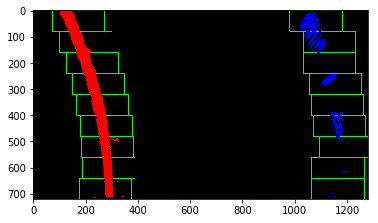

In [283]:
if __DEBUG__ :
    test_image = cv2.imread("test_images//test2.jpg")
    undistorted_test_image = undistort(test_image)
    undistorted_binary_image = lane_filter(undistorted_test_image)
    warped_binary_image = warp_image(undistorted_binary_image)
    out_img_sliding_window,left_fit,right_fit = fit_polynomial(warped_binary_image)
    plt.imshow(out_img_sliding_window)

In [278]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    margin = 100

    # choosing the activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

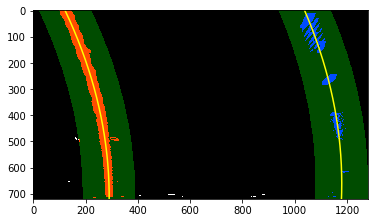

In [282]:
if __DEBUG__:
    out_image_privious_poly = search_around_poly(warped_binary_image,left_fit,right_fit)
    plt.imshow(out_image_privious_poly)

## Measuring the Curvature of the lanes in meters :

In [285]:
def measure_curvature_real(left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

if __DEBUG__:
    print(measure_curvature_real(left_fit,right_fit))

(1973.4085185768351, 1945.6197767541746)


## Shade the lane area

In [287]:
def plot_on_real_frame(undist, warped, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    
if __DEBUG__:
    plot_on_real_frame(undistorted_test_image, out_image_privious_poly, left_fit,right_fit)

error: OpenCV(4.0.0) C:\projects\opencv-python\opencv\modules\core\src\array.cpp:3229: error: (-215:Assertion failed) cn <= 4 in function 'cv::scalarToRawData'
